## I- Installation et import des bibliothèques Python

In [ ]:
!pip install split-folders

In [ ]:
# # GOOGLE Colab ONLY : Mount GOOGLE Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import splitfolders
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning
import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam, Nadam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, classification_report
from keras.applications import EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## II- Paramétrage des chemins des fichiers

In [ ]:
user_path = r"/content/drive/MyDrive/M2iFormation/RNCP"

source_folder = r"/content/drive/MyDrive/M2iFormation/RNCP/Images/Animaux"
split_folder = r"/content/drive/MyDrive/M2iFormation/RNCP/Images/AnimauxSplit"

train_dir = r"/content/drive/MyDrive/M2iFormation/RNCP/Images/AnimauxSplit/train"
val_dir = r"/content/drive/MyDrive/M2iFormation/RNCP/Images/AnimauxSplit/val"
test_dir = r"/content/drive/MyDrive/M2iFormation/RNCP/Images/AnimauxSplit/test"

fileh5_path = os.path.join(user_path, "EfficientNetV2B1_TRAIN_ManualSave.h5")
ft_fileh5_path = os.path.join(user_path, "EfficientNetV2B1_FT_ManualSave.h5")

## III- Distribution des photos entre les différents fichiers

In [ ]:
splitfolders.ratio(source_folder, output=split_folder,seed=42, ratio=(.7, .2, .1), group_prefix=None, move=False)

Copying files: 6000 files [05:59, 16.71 files/s]


## IV- Paramétrage et application des générateurs d'images

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = [0.9, 1.25],
    brightness_range = [0.5, 1.5],
    horizontal_flip = True,
    vertical_flip = True
)

val_datagen = ImageDataGenerator(
    rescale = 1./255)

test_datagen = ImageDataGenerator(
    rescale = 1./255)

In [ ]:
batch_size = 32
height = 240
width = 240
image_shape = (height, width)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    class_mode = "categorical",
    target_size = image_shape,
    batch_size = batch_size
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    class_mode = "categorical",
    target_size = image_shape,
    batch_size = batch_size,
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    class_mode = "categorical",
    target_size = image_shape,
    batch_size = batch_size,
    shuffle = False
)

Found 4200 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


## V- Modèle de base pré-entraîné

In [ ]:
ModelNameFunc = globals()["EfficientNetV2B1"]

base_model = ModelNameFunc(include_top = False, weights = "imagenet", include_preprocessing = False, input_shape = (height, width, 3))

28456008/28456008 [==============================] - 0s 0us/step


## VI- Définition de l'architecture du modèle

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation = "relu")(x)
x = Dropout(0.4)(x)
x = Dense(16, activation = "relu")(x)
x = BatchNormalization()(x)

predictions = Dense(3, activation = "softmax")(x)

model = Model(inputs = base_model.input, outputs = predictions)

## VII- Compilation et entraînement du modèle

In [ ]:
# Metrics (parameter average = "macro" by default )
precision = keras.metrics.Precision(name="Precision")
recall = keras.metrics.Recall(name="Recall")

model.compile(
    optimizer = "RMSprop",
    loss = "categorical_crossentropy",
    metrics = ["accuracy", precision, recall]
)

In [ ]:
# Define the early stopping
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5, verbose = 1, restore_best_weights = True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 5, verbose = 1, min_lr = 1e-6)

# Define the model checkpoint callback
checkpoint = ModelCheckpoint(filepath = os.path.join(user_path, "EfficientNetV2B1_TRAIN_MCPBest.h5"), monitor = "val_loss", save_freq = "epoch", save_weights_only = False, save_best_only = True, mode = "min", verbose = 1)

# Include it in the callbacks list
callbacks_list = [early_stopping, lr_scheduler, checkpoint]

history = model.fit(
    x = train_generator,
    steps_per_epoch = train_generator.samples // batch_size + 1,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size + 1,
    epochs = 30,
    verbose = 1,
    callbacks = callbacks_list
)

# Save the model
model.save(fileh5_path)

Epoch 1/30
132/132 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.8748 - Precision: 0.9034 - Recall: 0.8460
Epoch 1: val_loss improved from inf to 0.09061, saving model to /content/drive/MyDrive/M2iFormation/RNCP/EfficientNetV2B1_TRAIN_MCPBest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 1542s 11s/step - loss: 0.3625 - accuracy: 0.8748 - Precision: 0.9034 - Recall: 0.8460 - val_loss: 0.0906 - val_accuracy: 0.9725 - val_Precision: 0.9764 - val_Recall: 0.9658 - lr: 0.0010
Epoch 2/30
132/132 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9233 - Precision: 0.9357 - Recall: 0.9107
Epoch 2: val_loss improved from 0.09061 to 0.07818, saving model to /content/drive/MyDrive/M2iFormation/RNCP/EfficientNetV2B1_TRAIN_MCPBest.h5
132/132 [==============================] - 135s 1s/step - loss: 0.2331 - accuracy: 0.9233 - Precision: 0.9357 - Recall: 0.9107 - val_loss: 0.0782 - val_accuracy: 0.9733 - val_Precision: 0.9758 - val_Recall: 0.9725 - lr: 0.0010
Epoch 3/30
132/132 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9410 - Precision: 0.9490 - Recall: 0.9310
Epoch 3: val_loss did not improve from 0.07818
132/132 [==============================] - 128s 972ms/step - loss: 0.1815 - accuracy: 0.

## VIII- Evaluation du modèle

In [ ]:
results = model.evaluate(test_generator, batch_size = batch_size)

19/19 [==============================] - 151s 8s/step - loss: 0.0316 - accuracy: 0.9900 - Precision: 0.9900 - Recall: 0.9900


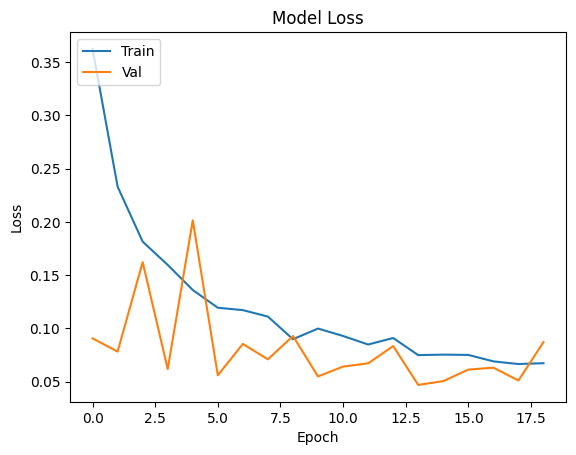

In [ ]:
# Plot the Loss graph
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc = "upper left")
plt.show()

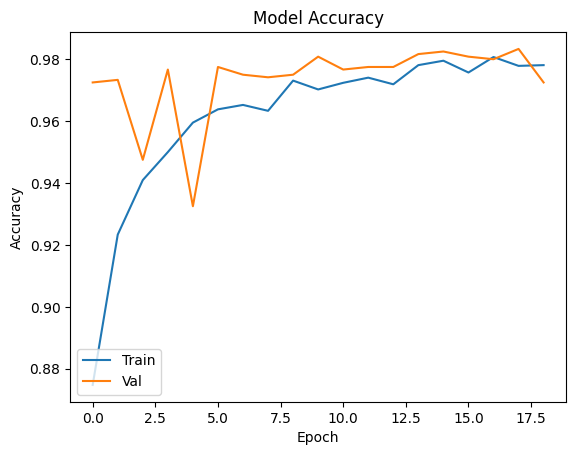

In [ ]:
# Plot the Accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc = "lower left")
plt.show()

## IX- Matrice de confusion

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(test_generator, steps = test_generator.samples // batch_size + 1)

# Convert predictions classes from one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Convert validation observations from one hot vectors
# Y_true = np.argmax(test_generator.classes, axis = 1)
# OR
Y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix")
print(cm)

# Retrieve class names (label)
names_from_dir = sorted(os.listdir(val_dir))
dict(enumerate(names_from_dir))
#OR
class_names = list(val_generator.class_indices.keys())
# Check if the both are similar
print(names_from_dir == class_names)

# Print the classification report
print("Classification Report")
print(classification_report(Y_true, Y_pred_classes, target_names = class_names))


19/19 [==============================] - 8s 250ms/step
Confusion Matrix
[[199   1   0]
 [  2 198   0]
 [  2   1 197]]
True
Classification Report
              precision    recall  f1-score   support

         BEE       0.98      0.99      0.99       200
   BUTTERFLY       0.99      0.99      0.99       200
     LADYBUG       1.00      0.98      0.99       200

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



In [ ]:
def plot_confusion_matrix(
    cm,
    classes,
    normalize = False,
    title = "Confusion matrix",
    cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis =1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Normalized confusion matrix
[[0.995 0.005 0.   ]
 [0.01  0.99  0.   ]
 [0.01  0.005 0.985]]


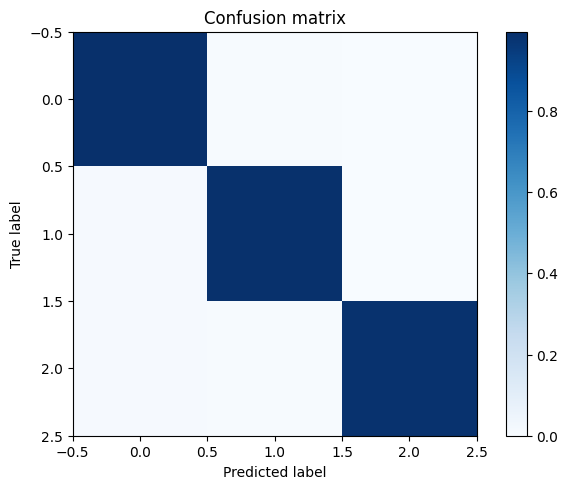

In [ ]:
plot_confusion_matrix(
    cm,
    class_names,
    normalize = True,
    title = "Confusion matrix",
    cmap = plt.cm.Blues
    )

## X- Re-entraînement (fine-tuning)

In [ ]:
# Unfreeze the base model
base_model.trainable = True

In [ ]:
model.compile(
    optimizer = RMSprop(learning_rate = 1e-5),
    loss = "categorical_crossentropy",
    metrics = ["accuracy", precision, recall]
)

In [ ]:
# Define the early stopping
ft_early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, verbose = 1, restore_best_weights = True)

# Define the learning rate scheduler
ft_lr_scheduler = ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 3, verbose = 1, min_lr = 1e-6)

# Define the model checkpoint callback
ft_checkpoint = ModelCheckpoint( filepath = os.path.join(user_path, "EfficientNetV2B1_FT_MCPBest.h5"), monitor = "val_loss", save_freq = "epoch", save_weights_only = False, save_best_only = True, mode = "min", verbose = 1)


# Resume training
ft_history = model.fit(
    x = train_generator,
    steps_per_epoch = train_generator.samples // batch_size + 1,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size + 1,
    epochs = 15,
    verbose = 1,
    callbacks = [ft_early_stopping, ft_lr_scheduler, ft_checkpoint]
)

# Save the Fine tuned model
model.save(ft_fileh5_path)

Epoch 1/15
132/132 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9837
Epoch 1: val_loss improved from inf to 0.04203, saving model to /content/drive/MyDrive/M2iFormation/RNCP/EfficientNetV2B1_FT_MCPBest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 187s 1s/step - loss: 0.0534 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9837 - val_loss: 0.0420 - val_accuracy: 0.9833 - val_Precision: 0.9841 - val_Recall: 0.9817 - lr: 1.0000e-05
Epoch 2/15
132/132 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9829
Epoch 2: val_loss improved from 0.04203 to 0.04015, saving model to /content/drive/MyDrive/M2iFormation/RNCP/EfficientNetV2B1_FT_MCPBest.h5
132/132 [==============================] - 135s 1s/step - loss: 0.0537 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9829 - val_loss: 0.0402 - val_accuracy: 0.9858 - val_Precision: 0.9883 - val_Recall: 0.9833 - lr: 1.0000e-05
Epoch 3/15
132/132 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9876 - Precision: 0.9892 - Recall: 0.9855
Epoch 3: val_loss improved from 0.04015 to 0.03802, saving model to /content/drive/MyDrive/M2iFormation/RNCP/EfficientNetV2B1_FT_MCP

## XI- Evaluation du réentraînement

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on Test Data")
results = model.evaluate(test_generator, batch_size = batch_size)

Evaluate on Test Data
19/19 [==============================] - 4s 237ms/step - loss: 0.0298 - accuracy: 0.9900 - Precision: 0.9900 - Recall: 0.9900


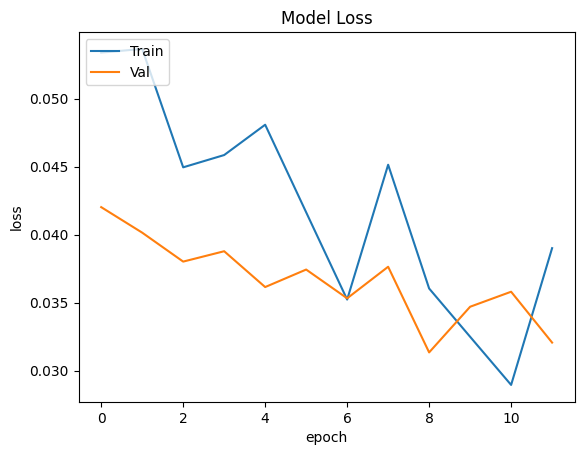

In [ ]:
# Plot the Loss graph
plt.plot(ft_history.history["loss"])
plt.plot(ft_history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Train", "Val"], loc = "upper left")
plt.show()

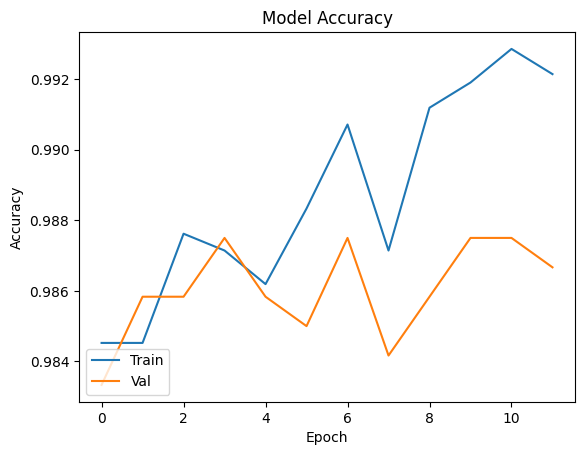

In [ ]:
# Plot the Accuracy graph
plt.plot(ft_history.history["accuracy"])
plt.plot(ft_history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc = "lower left")
plt.show()

## XII- Matrice de confusion du réentraînement

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(test_generator, steps = test_generator.samples // batch_size + 1)

# Convert predictions classes from one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Convert validation observations from one hot vectors
# Y_true = np.argmax(test_generator.classes, axis = 1)
# OR
Y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix")
print(cm)

# Retrieve class names (label)
names_from_dir = sorted(os.listdir(val_dir))
dict(enumerate(names_from_dir))
#OR
class_names = list(val_generator.class_indices.keys())
# Check if the both are similar
print(names_from_dir == class_names)

# Print the classification report
print("Classification Report")
print(classification_report(Y_true, Y_pred_classes, target_names = class_names, digits = 4))

19/19 [==============================] - 7s 289ms/step
Confusion Matrix
[[198   2   0]
 [  2 198   0]
 [  2   0 198]]
True
Classification Report
              precision    recall  f1-score   support

         BEE     0.9802    0.9900    0.9851       200
   BUTTERFLY     0.9900    0.9900    0.9900       200
     LADYBUG     1.0000    0.9900    0.9950       200

    accuracy                         0.9900       600
   macro avg     0.9901    0.9900    0.9900       600
weighted avg     0.9901    0.9900    0.9900       600



Normalized confusion matrix
[[0.99 0.01 0.  ]
 [0.01 0.99 0.  ]
 [0.01 0.   0.99]]


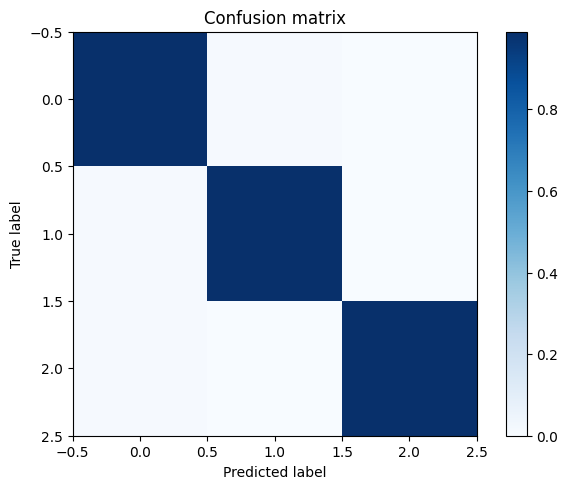

In [ ]:
plot_confusion_matrix(cm,
                      class_names,
                      normalize = True,
                      title = "Confusion matrix",
                      cmap = plt.cm.Blues
                      )